# Imports

In [2]:
from qiskit import QuantumCircuit
# noinspection PyUnresolvedReferences
from qiskit_aer import AerSimulator  # needed to make the qc.save_statevector available

# Setup Service and Backend

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
estimator = Estimator(backend)

# Circuit

In [7]:
from qiskit.quantum_info import Statevector


# See https://en.wikipedia.org/wiki/Five-qubit_error_correcting_code
def quantum_circuit_creator(state: Statevector):  # state must have 5 qubits
    qc = QuantumCircuit(10, 4)  # I use a 10th qubit to measure how much $\psi$ changed
    qc.prepare_state(state, [5, 6, 7, 8])
    qc.cx(0, 5)

    qc.cz(0, 6)
    # qc.ci(0,5) I don't think a Control Identity makes sense?

    qc.cz(0, 7)
    qc.cx(1, 6)
    qc.cx(2, 5)

    qc.cx(0, 8)
    qc.cz(1, 7)
    qc.cz(3, 5)

    qc.cz(1, 7)
    qc.cx(2, 6)
    qc.cx(3, 5)

    qc.cx(1, 8)
    qc.cz(2, 7)

    qc.cz(2, 8)
    qc.cx(3, 7)

    qc.cz(3, 8)

    qc.measure([5, 6, 7, 8], [0, 1, 2, 3])
    qc.barrier()
    qc.draw("mpl")
    
    return qc
    

qc = quantum_circuit_creator(state=Statevector.from_label("+-rl"))

In [8]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

n_qubits = 127

# mat = np.real(random_hermitian(n_qubits, seed=1234))
qc.measure_all()

In [9]:
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_circuit = pm.run(qc)

# Setup Sampler

In [10]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend=backend)

# Run

In [11]:
job = sampler.run([isa_circuit])
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cs5mjah965y000859pgg
>>> Job Status: QUEUED


In [12]:
result = job.result()

# Get results for the first (and only) PUB
pub_result = result[0]
print(f"Counts for the meas output register: {pub_result.data.meas.get_counts()}")

Counts for the meas output register: {'0110100001': 11, '0010000011': 52, '0111000000': 48, '0101000011': 25, '0100000011': 72, '0001000000': 66, '0101100000': 84, '0110100111': 10, '0011000110': 10, '0110000010': 114, '0010100000': 25, '0100100111': 16, '0011001000': 5, '0100010010': 4, '0101001010': 13, '0100001010': 16, '0010000010': 84, '0011100100': 10, '0000000010': 94, '0010100011': 39, '0010100101': 1, '0101000100': 35, '0111000010': 59, '0000000000': 46, '0000100111': 10, '0001001101': 1, '0110100010': 88, '0101100011': 34, '0000000100': 22, '0011100011': 18, '0110100011': 29, '0000100010': 129, '0100000010': 174, '0011100000': 40, '0011000101': 7, '0111000001': 33, '0111100010': 43, '0100000100': 28, '0111100100': 10, '0101000000': 103, '0111100011': 22, '0000000011': 43, '0100001011': 3, '0011100001': 16, '0010100111': 4, '0000101010': 9, '0111001000': 8, '0110001011': 12, '0100100010': 182, '0011100111': 2, '0000000110': 19, '0110000001': 14, '0001000010': 53, '0011000010':

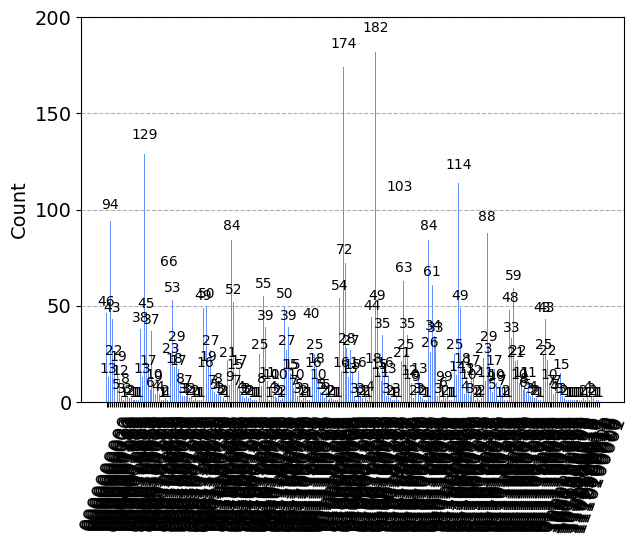

In [13]:
from qiskit.visualization import plot_histogram

plot_histogram(pub_result.data.meas.get_counts())

In [26]:
" | ".join([f"{v}: {k}" for k,v in sorted(pub_result.data.meas.get_counts().items(), key = lambda x: -x[1])])

'182: 0100100010 | 174: 0100000010 | 129: 0000100010 | 114: 0110000010 | 103: 0101000000 | 94: 0000000010 | 88: 0110100010 | 84: 0101100000 | 84: 0010000010 | 72: 0100000011 | 66: 0001000000 | 63: 0101000010 | 61: 0101100010 | 59: 0111000010 | 55: 0010100010 | 54: 0100000000 | 53: 0001000010 | 52: 0010000011 | 50: 0001100010 | 50: 0011000000 | 49: 0110000011 | 49: 0100100011 | 49: 0001100000 | 48: 0111000000 | 46: 0000000000 | 45: 0000100011 | 44: 0100100000 | 43: 0111100010 | 43: 0000000011 | 43: 0111100000 | 40: 0011100000 | 39: 0010100011 | 39: 0011000010 | 38: 0000100000 | 37: 0000100110 | 35: 0101000100 | 35: 0100100110 | 34: 0101100011 | 33: 0111000001 | 33: 0101100100 | 29: 0110100011 | 29: 0001000100 | 28: 0100000100 | 27: 0100000110 | 27: 0011000001 | 27: 0001100100 | 26: 0101100001 | 25: 0101000011 | 25: 0010100000 | 25: 0011100010 | 25: 0111100001 | 25: 0110000000 | 23: 0001000001 | 23: 0110100000 | 22: 0000000100 | 22: 0111100011 | 22: 0111000100 | 21: 0111000011 | 21: 0010